In [1]:
import os
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

SyntaxError: invalid syntax (utils.py, line 173)

In [2]:
dmethod = 2
#
if dmethod == 0:
    client = None
if dmethod == 1:
    from dask.distributed import Client
    scheduler = os.getenv('DATAWORK')+'/dask/scheduler.json'
    client = Client(scheduler_file=scheduler)
elif dmethod == 2:
    from dask_jobqueue import PBSCluster
    local_dir = os.getenv('TMPDIR')
    cluster = PBSCluster(local_directory=local_dir)
    #cluster = PBSCluster(local_directory=local_dir, threads=14, processes=1, memory='10GB')    
    #print(cluster.job_script())
    w = cluster.start_workers(10)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# you need to wait for workers to spin up
#if dmethod == 2:
#    cluster.scheduler

In [4]:
# get dask handles and check dask server status
if dmethod == 2:
    from dask.distributed import Client
    client = Client(cluster)

In [19]:
client

Client Scheduler: tcp://10.148.1.25:52328 Dashboard: http://10.148.1.25:8787/status,Cluster Workers: 20 Cores: 80 Memory: 1000.00 GB


---

# automatic extraction of all variables

In [28]:
grid_dir = root_data_dir+'grid/'
out_dir = datawork+'iwsst_mit/'

def extract(v, it, face, i, j, pref=''):
    
    data_dir = root_data_dir+v+'/'

    iters, time = get_iters_time(v, data_dir, delta_t=25.)
    
    p = 'C'
    if v is 'SSU':
        p = 'W'
    elif v is 'SSV':
        p = 'S'
    ds = get_compressed_data(v, data_dir, grid_dir, iters=iters, time=time, client=client, point=p)
    ds = ds.chunk({'face': 1})
    #print(ds)

    file_out = out_dir+pref+v+'.nc'
    #ds[v].isel(time=t, face=face, i=i, j=j).to_netcdf(file_out, mode='w', unlimited_dims='time')
    dv = ds[v].sel(time=time.sel(iters=it)).isel(face=face, i=i, j=j)
    dv = dv.load()
    dv.to_netcdf(file_out, mode='w', unlimited_dims='time')


In [27]:
iters, time = get_iters_time('Eta', data_rdir+'Eta/', delta_t=25.)
siters = iters.sel(time=slice(152*86400.,178*86400.))
print(time.sel(iters=siters))

<xarray.DataArray (time: 625)>
array([13132800., 13136400., 13140000., ..., 15372000., 15375600., 15379200.])
Coordinates:
    iters    (time) int64 525312 525456 525600 525744 525888 526032 526176 ...
  * time     (time) float64 1.313e+07 1.314e+07 1.314e+07 1.314e+07 ...


In [ ]:
V = ['Eta', 'SST', 'SSU', 'SSV']
#V = ['Eta', 'SST']
#V = ['SSU']

iters, time = get_iters_time('Eta', data_rdir+'Eta/', delta_t=25.)
siters = iters.sel(time=slice(152*86400.,178*86400.))

ext = {}
ext['mad'] = {'iters': siters, 'face': 1, 'i': slice(3000,None), 'j': slice(1000,4000)}
ext['nwa'] = {'iters': siters, 'face': 4, 'i': slice(2000,4000), 'j': slice(1500,3500)}

for key, e in ext.items():
    print('face = %d' %e['face'])
    for v in V:
        print(v)
        extract(v, e['iters'], e['face'], e['i'], e['j'], pref=key+'_')

face = 1
Eta


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


SST
SSU


---

# manual exploration in order to get index slices

In [41]:
data_dir = root_data_dir+'Eta/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

ds = get_compressed_data('Eta', data_dir, grid_dir, iters=iters, time=time, client=client)
ds = ds.chunk({'face': 1})
print(ds)
print('\n data size: %.1f GB' %(ds['Eta'].nbytes / 1e9))
print('\n data size (1 face): %.1f GB' %(ds['Eta'].isel(face=1).nbytes / 1e9))

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:721: UserWarning: Couldn't find available_diagnostics.log in . Using default version.
  "in %s. Using default version." % data_dir)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 8218)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(1, 4320, 4320)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 4320, 4320), chunksize=(

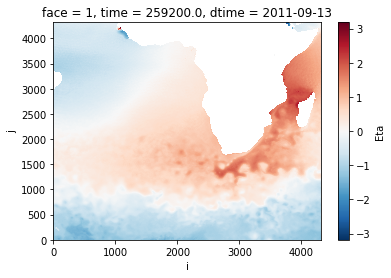

In [42]:
ds['Eta'].isel(time=0, face=1).plot()

In [ ]:
ds['Eta'].isel(time=0, face=4).plot()

### produce a netcdf file

In [ ]:
ds.isel(time=slice(0,24), face=1)

In [ ]:
file_out = os.getenv('DATAWORK')+'/ssh_extract.nc'
#ds.isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time') # not working, weird incompatible chunk error
ds['Eta'].isel(time=slice(0,24), face=1).to_netcdf(file_out, mode='w', unlimited_dims='time')

---

In [43]:
# kill workers
cluster.stop_workers(cluster.jobs)